In [1]:
install.packages("xgboost")
install.packages("caret")
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
load("TP4.Rdata")

# Ejercicio 1: Complejidad del clasificador en boosting

In [ ]:
require(xgboost)

boosting.predict <- function(x.train, y.train, x.test, y.test, complexity) {
  XGB.nrounds=200
  XGB.eta=0.1
  XGB.max.depth=complexity

  m.xgb <- xgboost(
    data = x.train,
    label = as.integer(y.train) - 1,
    objective = "binary:hinge",
    nrounds = XGB.nrounds,
    early_stopping_rounds = 1000,
    eta = XGB.eta,
    max.depth = XGB.max.depth,
    colsample_bytree = 1,
    verbose = 0,
    subsample = 1
  )

  y.pred <- predict(m.xgb, x.test)

  error <- mean(y.pred != (as.integer(y.test) - 1))
  return(list(error = error, model = m.xgb))
}

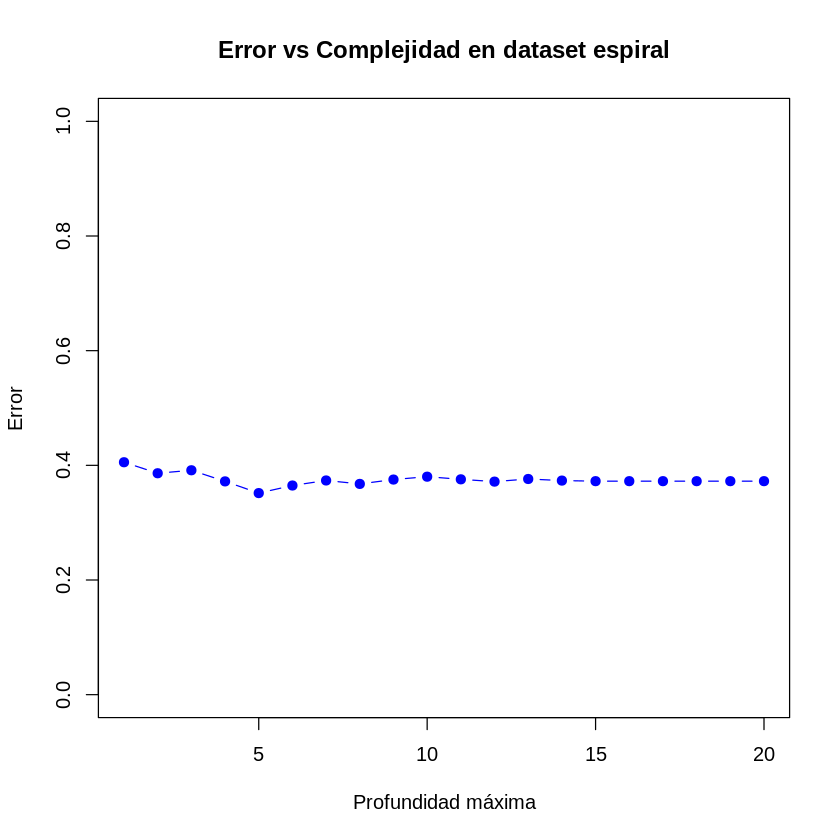

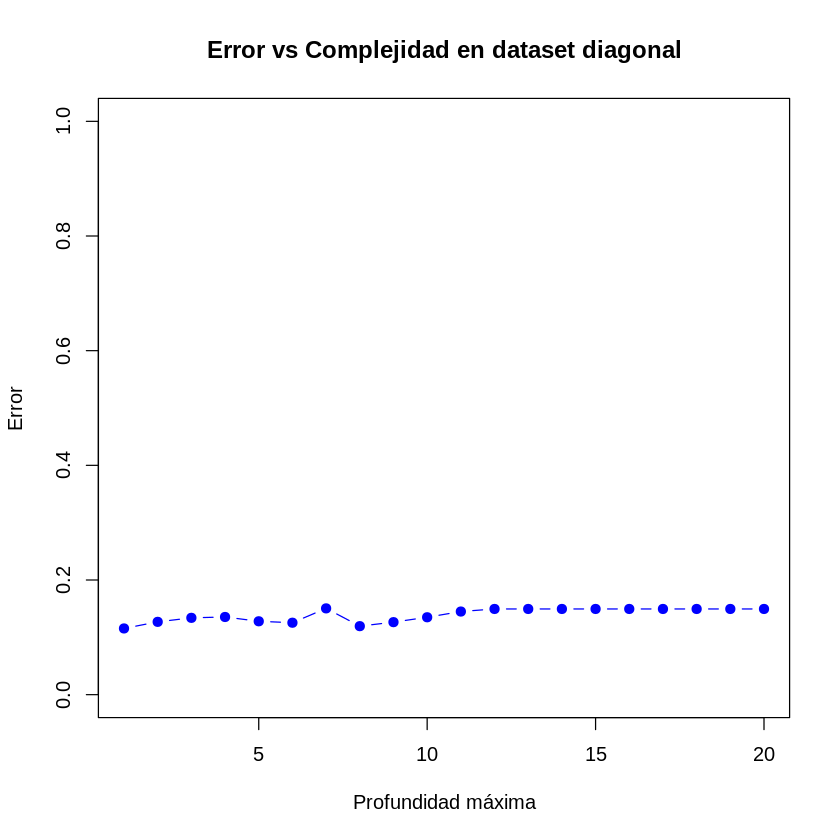

In [ ]:
x.esp.train<-as.matrix(esp_train[,1:2])
y.esp.train<-esp_train[,3]
x.esp.test<-as.matrix(esp_test[,1:2])
y.esp.test<-esp_test[,3]

x.diag.train<-as.matrix(diag_train[,1:2])
y.diag.train<-diag_train[,3]
x.diag.test<-as.matrix(diag_test[,1:2])
y.diag.test<-diag_test[,3]

test.esp.error <- 1:20
test.diag.error <- 1:20
for (complexity in 1:20) {
  test.esp.error[complexity] <- boosting.predict(x.esp.train, y.esp.train, x.esp.test, y.esp.test, complexity)$error
  test.diag.error[complexity] <- boosting.predict(x.diag.train, y.diag.train, x.diag.test, y.diag.test, complexity)$error
}

plot(
  1:20, test.esp.error,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad máxima",
  ylab = "Error",
  ylim = c(0,1),
  main = "Error vs Complejidad en dataset espiral"
)

plot(
  1:20, test.diag.error,
  type = "b",
  col = "blue",
  pch = 19,
  xlab = "Profundidad máxima",
  ylab = "Error",
  ylim = c(0,1),
  main = "Error vs Complejidad en dataset diagonal"
)

Vemos que la profundidad del árbol no pareciera tener un efecto notorio en el error obtenido con gradient boosting. Esto podría suceder porque incluso aunque la profundidad sea baja, como es un método de ensemble se combinan las distintas soluciones y se consigue modelar el problema.
Aunque en casos más complicados como el dataset diagonal el error es bastante alto.

# Ejercicio 2: mtry en random forest

In [ ]:
calculate.features.fractions <- function(num.features) {
  features.fractions <- floor(num.features / 2 ^ (0:floor(log(num.features, base = 2))))

  return(features.fractions)
}

In [ ]:
library(randomForest)

no_run <- 5

rrl.list.num.features <- calculate.features.fractions(ncol(RRL)-1)

oob_errors <- 1:length(rrl.list.num.features)

for (i in 1:length(rrl.list.num.features)) {

  run_error <- 1:no_run

  for (run in 1:no_run) {
    model <- randomForest(RRL[,-70], RRL[,70], mtry = rrl.list.num.features[i], importance = TRUE)
    run_error[run] <- model$err.rate[nrow(model$err.rate), "OOB"]
  }

  oob_errors[i] <- mean(run_error)
}

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



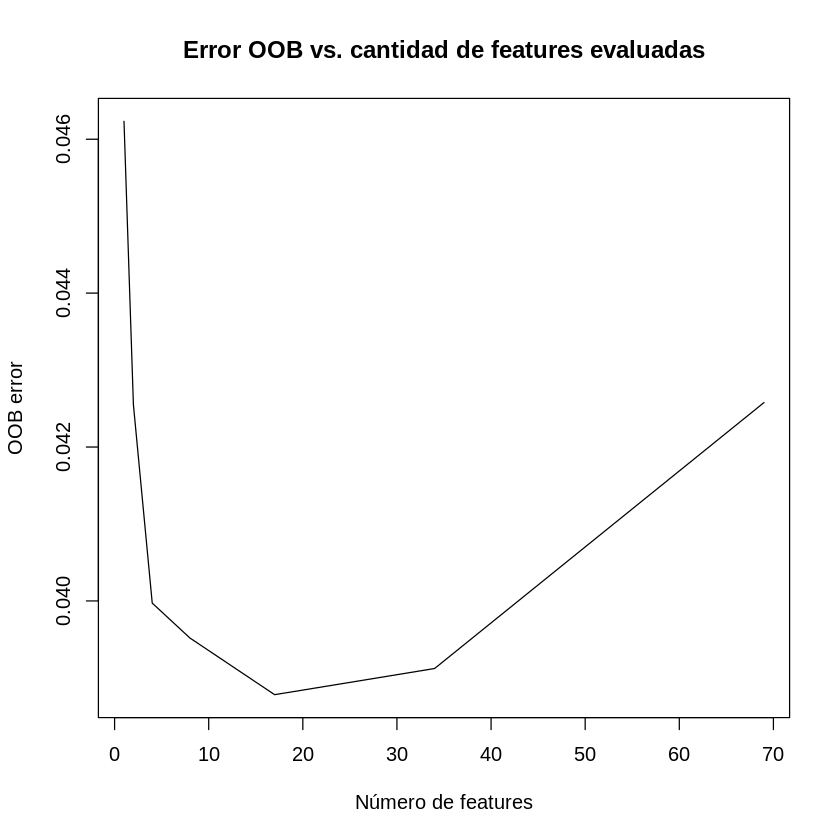

In [ ]:
plot(rrl.list.num.features, oob_errors, type="l",
     main = "Error OOB vs. cantidad de features evaluadas", ylab = "OOB error",
     xlab = "Número de features")

Vemos en este caso que cambiar el número de features que se toman en cada iteración tampoco tiene tanto efecto en el resultado (error OOB).
Esto hace que el método tenga la característica de que no haya que optimizar ningún parámetro e incluso así obtener una buena estimación del error.

# Ejercicio 3: Análisis dataset lampone

In [ ]:
load("lampone.Rdata")

## Random forest

In [ ]:
lampone.y <- (lampone[,143])
lampone.x <- (lampone[,-c(1,143,144)])

non_constant_cols <- sapply(lampone.x, var) > 0

lampone.x <- as.matrix(lampone.x[,non_constant_cols])

In [ ]:
model <- randomForest(lampone.x, lampone.y)
error <- model$err.rate[nrow(model$err.rate), "OOB"]

model


Call:
 randomForest(x = lampone.x, y = lampone.y) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 11

        OOB estimate of  error rate: 8.16%
Confusion matrix:
    2 10 class.error
2  19  3  0.13636364
10  1 26  0.03703704

En este caso aplicamos el método random forest. Aprovechando que no es necesario optimizar algún parámetro y también que ya da una buena estimación del error, usamos todos los datos para el entrenamiento.
Conseguimos un buen resultado de menos de 10% de error.

## Boosting

In [ ]:
library(caret)

lampone.y.mat <- as.matrix(lampone.y)

train_index <- createDataPartition(lampone.y.mat, p = 0.8, list = FALSE)

x.lampone.train <- lampone.x[train_index,]
y.lampone.train <- lampone.y.mat[train_index,]

x.lampone.test <- lampone.x[-train_index,]
y.lampone.test <- lampone.y.mat[-train_index, , drop = FALSE]

In [ ]:
XGB.nrounds=200
XGB.eta=0.1

m.xgb <- xgboost(
  data = x.lampone.train,
  label = as.integer(as.factor(y.lampone.train)) - 1,
  objective = "binary:hinge",
  nrounds = XGB.nrounds,
  early_stopping_rounds = 1000,
  eta = XGB.eta,
  colsample_bytree = 1,
  verbose = 0,
  subsample = 1
)

y.pred <- predict(m.xgb, x.lampone.test)

error <- mean(y.pred != (as.integer(as.factor(y.lampone.test)) - 1))
print(error)

[1] 0.1111111


Para boosting, como no hay una estimación del error OOB, separamos los datos en dos conjuntos: train y test.
Conseguimos un error de 11%, algo peor que el de random forest. Esto puede ser porque ahora estamos usando menos datos, agregado a que el dataset lampone viene con pocas filas.

## SVM

Para aplicar SVM primero definimos algunas funciones para evitar la repetición.

In [2]:
library(e1071)

find_best_svm_polynomial_model <- function(x.train, y.train, x.validation, y.validation, C_values, degrees, scale) {
  best_model <- NULL
  best_accuracy <- 0

  for (C in C_values) {
    for (degree in degrees) {
      model <- svm(x=x.train, y=y.train, type = 'C-classification', scale = scale,
                  kernel = "polynomial", cost = C, degree = degree)

      predictions <- predict(model, x.validation)

      accuracy <- mean(predictions == y.validation)

      if (accuracy > best_accuracy) {
        best_accuracy <- accuracy
        best_model <- model
      }
    }
  }
  return(best_model)
}

En el caso del kernel polinomial, se toman valores para el costo de 10^-5 hasta 10^5, y para el grado de 1 a 5.
Una vez que se hace ese barrido, después se refina un poco la búsqueda de valores para el costo. Probando 10 valores más en los intervalos que mejores resultados dieron.

In [ ]:
optimal_svm_polynomial_model <- function(x.train, y.train, x.test, y.test, x.validation, y.validation, scale = FALSE) {
  C_values <- 10^(-5:5)
  degrees <- 1:5

  model <- find_best_svm_polynomial_model(x.train, y.train, x.validation, y.validation, C_values, degrees, scale)

  best_cost <- model$cost
  best_degree <- model$degree

  narrowed_C_values <- seq(from = best_cost/10, to = best_cost*10, length.out = 10)
  narrowed_C_values <- c(narrowed_C_values, best_cost)

  model <- find_best_svm_polynomial_model(x.train, y.train, x.validation, y.validation, narrowed_C_values, c(best_degree), scale)

  predictions <- predict(model, x.test)
  accuracy <- sum(predictions == y.test) / length(y.test) * 100

  print(model)
  print(paste("Accuracy:",round(accuracy,2), "%"))
}


In [ ]:
library(e1071)

find_best_svm_radial_model <- function(x.train, y.train, x.validation, y.validation, C_values, gammas, scale) {
  best_model <- NULL
  best_accuracy <- 0

  for (C in C_values) {
    for (gamma in gammas) {
      model <- svm(x=x.train, y=y.train, type = 'C-classification', scale = scale,
                  kernel = "radial", cost = C, gamma = gamma)

      predictions <- predict(model, x.validation)

      accuracy <- mean(predictions == y.validation)

      if (accuracy > best_accuracy) {
        best_accuracy <- accuracy
        best_model <- model
      }
    }
  }

  return(best_model)
}

Para el kernel radial se hace un proceso similar al kernel polinomial.
La diferencia es en el parámetro gamma. Se prueba con distintos factores de la distancia media entre puntos. En el caso del dataset RRL, funciona mucho mejor tomar el gamma por defecto del método: 1/ nro de features.

In [ ]:
optimal_svm_radial_model <- function(x.train, y.train, x.test, y.test, x.validation, y.validation, scale = FALSE, default_gamma = FALSE) {
  C_values <- 10^(-5:5)

  if (default_gamma) {
    gammas <- c(1/ncol(x.train))
  } else {
    distance_matrix <- dist(x.train)
    distance_matrix_full <- as.matrix(distance_matrix)
    mean_distance <- mean(distance_matrix)
    gammas <- seq(0.1, 2, by=0.1) * mean_distance
  }

  model <- find_best_svm_radial_model(x.train, y.train, x.validation, y.validation, C_values, gammas, scale)

  best_cost <- model$cost
  best_gamma <- model$gamma

  narrowed_C_values <- seq(from = best_cost/10, to = best_cost*10, length.out = 10)
  narrowed_C_values <- c(narrowed_C_values, best_cost)

  model <- find_best_svm_radial_model(x.train, y.train, x.validation, y.validation, narrowed_C_values, c(best_gamma), scale)

  predictions <- predict(model, x.test)
  accuracy <- sum(predictions == y.test) / length(y.test) * 100

  print(model)
  print(paste("Accuracy:",round(accuracy,2), "%"))
}

In [ ]:
library(caret)

lampone.y.mat <- as.matrix(lampone.y)

train_index <- createDataPartition(lampone.y.mat, p = 0.6, list = FALSE)

x.lampone.train <- lampone.x[train_index,]
y.lampone.train <- lampone.y.mat[train_index,]

remaining_data_x <- lampone.x[-train_index,]
remaining_data_y <- lampone.y.mat[-train_index, , drop = FALSE]

validation_index <- createDataPartition(remaining_data_y, p = 0.5, list = FALSE)

x.lampone.validation <- remaining_data_x[validation_index, ]
y.lampone.validation <- remaining_data_y[validation_index, ]
x.lampone.test <- remaining_data_x[-validation_index, ]
y.lampone.test <- remaining_data_y[-validation_index, , drop = FALSE]

In [ ]:
optimal_svm_polynomial_model(x.lampone.train, y.lampone.train, x.lampone.test, y.lampone.test, x.lampone.validation, y.lampone.validation)


Call:
svm.default(x = x.train, y = y.train, scale = scale, type = "C-classification", 
    kernel = "polynomial", degree = degree, cost = C)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  1e-06 
     degree:  3 
     coef.0:  0 

Number of Support Vectors:  11

[1] "Accuracy: 88.89 %"


Con kernel polinomial se consigue un clasificador con accuracy de casi 90%. Pero hay que tener en cuenta que el conjunto de test es muy chico. Este resultado puede depender mucho de cómo está particionado el dataset porque tiene pocos datos.

In [ ]:
optimal_svm_radial_model(x.lampone.train, y.lampone.train, x.lampone.test, y.lampone.test, x.lampone.validation, y.lampone.validation)


Call:
svm.default(x = x.train, y = y.train, scale = scale, type = "C-classification", 
    kernel = "radial", gamma = gamma, cost = C)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1e-06 

Number of Support Vectors:  28

[1] "Accuracy: 55.56 %"


Con kernel RBF el resultado es bastante peor con accuracy de 55% en el conjunto de test.

# Ejercicio 4: clasificación en dataset RRL

A continuación se prueban una vez más los métodos de clasificación, pero en este caso sobre el dataset RRL.

In [ ]:
RRL.y <- RRL[,70]
RRL.x <- RRL[,-70]

In [ ]:
RRL.x.mat <- as.matrix(RRL.x)
RRL.y.mat <- as.matrix(RRL.y)

train_index <- createDataPartition(RRL.y.mat, p = 0.6, list = FALSE)

x.RRL.train <- RRL.x.mat[train_index,]
y.RRL.train <- RRL.y.mat[train_index,]

remaining_data_x <- RRL.x.mat[-train_index,]
remaining_data_y <- RRL.y.mat[-train_index, , drop = FALSE]

validation_index <- createDataPartition(remaining_data_y, p = 0.5, list = FALSE)

x.RRL.validation <- remaining_data_x[validation_index, ]
y.RRL.validation <- remaining_data_y[validation_index, ]
x.RRL.test <- remaining_data_x[-validation_index, ]
y.RRL.test <- remaining_data_y[-validation_index, , drop = FALSE]

In [ ]:
model <- randomForest(RRL.x, RRL.y)
error <- model$err.rate[nrow(model$err.rate), "OOB"]

model


Call:
 randomForest(x = RRL.x, y = RRL.y) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 8

        OOB estimate of  error rate: 3.91%
Confusion matrix:
     0    1 class.error
0 3423  107  0.03031161
1  169 3361  0.04787535

Random forest consigue una estimación OOB del error muy buena, de alrededor del 4%.

In [ ]:
XGB.nrounds=200
XGB.eta=0.1

m.xgb <- xgboost(
  data = x.RRL.train,
  label = as.integer(as.factor(y.RRL.train)) - 1,
  objective = "binary:hinge",
  nrounds = 200,
  early_stopping_rounds = 1000,
  eta = XGB.eta,
  colsample_bytree = 1,
  verbose = 0,
  subsample = 1
)

y.pred <- predict(m.xgb, x.RRL.test)

error <- mean(y.pred != (as.integer(as.factor(y.RRL.test)) - 1))
print(error)

[1] 0.04745042


En este caso, como hay más datos, el resultado es que gradient boosting clasifica de manera muy similar a random forest. Consigue alrededor de un 4% de error de test.

In [ ]:
optimal_svm_polynomial_model(x.RRL.train, y.RRL.train, x.RRL.test, y.RRL.test, x.RRL.validation, y.RRL.validation, scale = TRUE)


Call:
svm.default(x = x.train, y = y.train, scale = scale, type = "C-classification", 
    kernel = "polynomial", degree = degree, cost = C)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  polynomial 
       cost:  8900 
     degree:  1 
     coef.0:  0 

Number of Support Vectors:  918

[1] "Accuracy: 91.01 %"


In [ ]:
optimal_svm_radial_model(x.RRL.train, y.RRL.train, x.RRL.test, y.RRL.test, x.RRL.validation, y.RRL.validation, scale = TRUE, default_gamma = TRUE)


Call:
svm.default(x = x.train, y = y.train, scale = scale, type = "C-classification", 
    kernel = "radial", gamma = gamma, cost = C)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  12 

Number of Support Vectors:  1192

[1] "Accuracy: 91.15 %"


Finalmente, se prueba con SVM. Ambos kernels obtienen un accuracy mayor al 90%. Notar que en el kernel radial se tuvo que utilizar el gamma por defecto del método en R. Esto se hizo así porque tomar distintos factores de la media de las distancias entre puntos daba un resultado malo.